### Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists')
else:
  print("Downloading helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

# Create helper function to calculate the training time
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = device):
  '''
  Prints the difference between the start and end time
  '''
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

helper_functions.py already exists


### Getting and loading the data

In [ ]:
# Getting the training data

train_data = datasets.FashionMNIST(root='data',
                                   train=True, # Training or test dataset
                                   download=True,
                                   transform=torchvision.transforms.ToTensor(), # how do we transform the data
                                   target_transform=None # how do we transform the labels/targets
                                   )


test_data = datasets.FashionMNIST(root='data',
                                   train=False, # Training or test dataset
                                   download=True,
                                   transform=torchvision.transforms.ToTensor(), # how do we transform the data
                                   target_transform=None # how do we transform the labels/targets
                                  )


class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# Preparing the Data Loader

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f7628892b90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f75343f8f50>)

### Functionizing the train and test steps

In [ ]:
# Functionize the training process

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y,
                             y_pred = y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

  return train_loss, train_acc



In [ ]:
# Functionize the testing process

def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  '''Performs a testing step on a PyTorch model.'''

  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y,
                              y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
  return test_loss, test_acc

### Creating the model architecture

In [ ]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(0.25)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units*2,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units*2,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(0.5)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7,
                  out_features = 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=256, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print("Output shape of classifier: {x.shape}")
    return x

In [ ]:
torch.manual_seed(42)
model_v2 = FashionMNISTModelV2(input_shape = 1,
                               hidden_units = 32,
                               output_shape = len(class_names)).to(device)
model_v2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [ ]:
rand_image_tensor = torch.randn(size = (1, 28, 28))

model_v2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.1371, -0.1419, -0.5185, -0.0225, -0.4905,  0.3824, -0.2676, -0.7027,
         -0.4365,  0.0229]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)

images = torch.randn(size = (32, 3, 64, 64)).to(device)
test_image = images[0]

print(f"Image batch shape: {images.shape}\n")
print(f"Shape of the test image: {test_image.shape}\n")
print(f"Test image:\n{test_image}")


Image batch shape: torch.Size([32, 3, 64, 64])

Shape of the test image: torch.Size([3, 64, 64])

Test image:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

      

In [ ]:
# Understanding the hyperparameters of Conv2d

conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 1).to(device)

conv_output = conv_layer(test_image.unsqueeze(dim = 0))

print(f"Shape of the convolution output: {conv_output.shape}")

Shape of the convolution output: torch.Size([1, 10, 64, 64])


In [ ]:
# Stepping throuhg MaxPool2d

max_pool_layer = nn.MaxPool2d(kernel_size = 2).to(device)

max_pool_output = max_pool_layer(conv_output)

print(f"Shape of the max pool output: {max_pool_output.shape}")

Shape of the max pool output: torch.Size([1, 10, 32, 32])


In [ ]:
torch.manual_seed(42)

random_tensor = torch.randn(size = (1, 1, 2, 2))

max_pool_layer = nn.MaxPool2d(kernel_size = 2)

max_pool_output = max_pool_layer(random_tensor)

print(f"Random tensor:\n{random_tensor}\n\nTensor shape: {random_tensor.shape}\n\n")
print(f"Max pool output:\n{max_pool_output}]\n\nOutput shape: {max_pool_output.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])

Tensor shape: torch.Size([1, 1, 2, 2])


Max pool output:
tensor([[[[0.3367]]]])]

Output shape: torch.Size([1, 1, 1, 1])


### Setting up loss function and optimizer, creating the trainig loop

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_v2.parameters(),
                            lr = 0.1)

In [ ]:
from math import e
# Training and testing
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()
epochs = 30
train_loss_list, train_acc_list, test_loss_list, tess_acc_list = [], [], [], []
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc= train_step(model = model_v2,
                                                        data_loader= train_dataloader,
                                                        loss_fn= loss_fn,
                                                        optimizer = optimizer,
                                                        accuracy_fn=accuracy_fn,
                                                        device = device)
  test_loss, test_acc = test_step(model = model_v2,
                                                      data_loader = test_dataloader,
                                                      loss_fn = loss_fn,
                                                      optimizer = optimizer,
                                                      accuracy_fn = accuracy_fn,
                                                      device = device)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  test_loss_list.append(test_loss)
  tess_acc_list.append(test_acc)
end_time = timer()
total_time = print_train_time(start_time, end_time, device = device)


Epoch: 0
-------
Train loss: 0.56362 | Train acc: 79.35%
Test loss: 0.33889 | Test acc: 87.43%
Epoch: 1
-------
Train loss: 0.36350 | Train acc: 86.73%
Test loss: 0.28505 | Test acc: 89.53%
Epoch: 2
-------
Train loss: 0.31822 | Train acc: 88.47%
Test loss: 0.29052 | Test acc: 89.34%
Epoch: 3
-------
Train loss: 0.29504 | Train acc: 89.28%
Test loss: 0.23972 | Test acc: 91.19%
Epoch: 4
-------
Train loss: 0.27659 | Train acc: 89.96%
Test loss: 0.23376 | Test acc: 91.35%
Epoch: 5
-------
Train loss: 0.26864 | Train acc: 90.22%
Test loss: 0.23985 | Test acc: 91.33%
Epoch: 6
-------
Train loss: 0.25806 | Train acc: 90.66%
Test loss: 0.21866 | Test acc: 92.00%
Epoch: 7
-------
Train loss: 0.25038 | Train acc: 90.86%
Test loss: 0.23212 | Test acc: 91.22%
Epoch: 8
-------
Train loss: 0.24417 | Train acc: 91.09%
Test loss: 0.21206 | Test acc: 92.22%
Epoch: 9
-------
Train loss: 0.23625 | Train acc: 91.33%
Test loss: 0.20625 | Test acc: 92.57%
Epoch: 10
-------
Train loss: 0.23298 | Train acc:

### Plotting the loss and accuracy curves

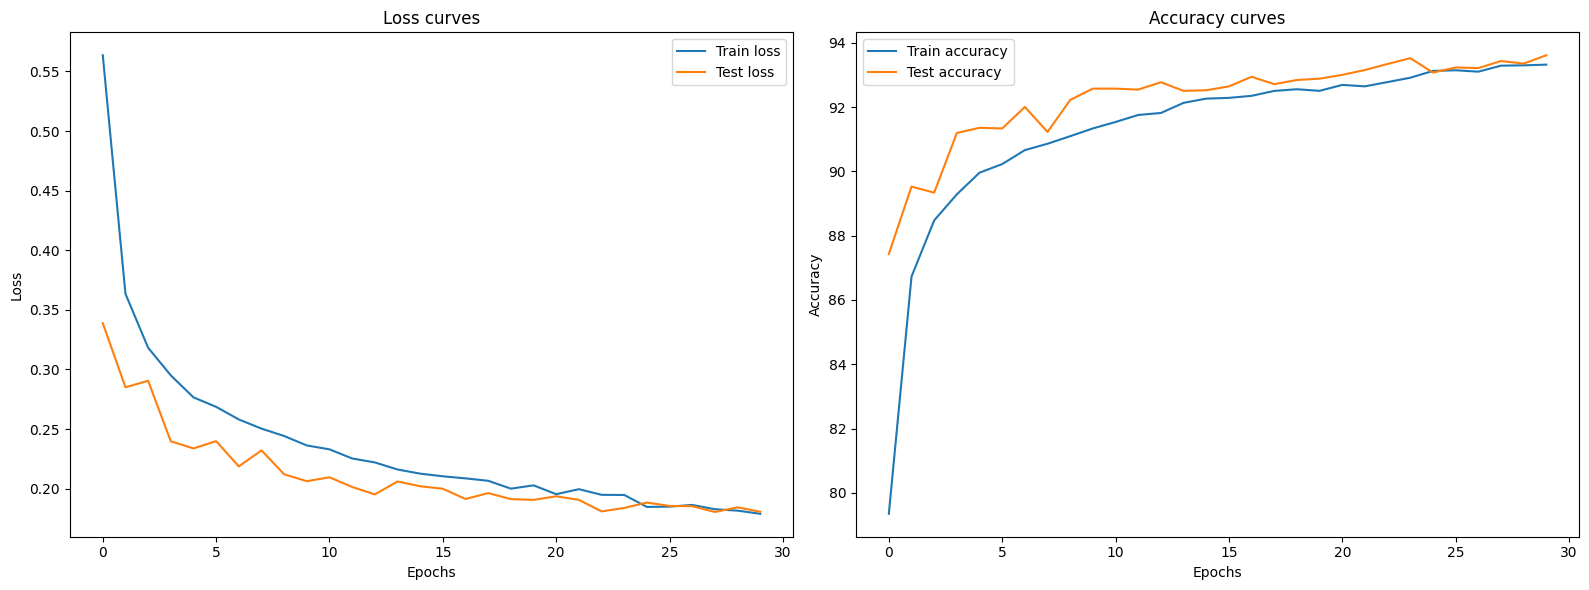

In [ ]:
import matplotlib.pyplot as plt

def to_float(t):
    return t.cpu().item() if hasattr(t, 'cpu') else t

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Loss curves
axes[0].plot([to_float(t) for t in train_loss_list], label='Train loss')
axes[0].plot([to_float(t) for t in test_loss_list], label='Test loss')
axes[0].set_title('Loss curves')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot 2: Accuracy curves
axes[1].plot([to_float(t) for t in train_acc_list], label='Train accuracy')
axes[1].plot([to_float(t) for t in tess_acc_list], label='Test accuracy')
axes[1].set_title('Accuracy curves')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
'''model_2_results = eval_model(model = model_v2,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn,
                             device = device)
model_2_results'''

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  ''''''

  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)